In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [20]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=10, repeats=1):

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=123)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring='r2',
                               verbose=True, return_train_score=True, n_jobs=4)

        gsearch.fit(X,y)
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_
        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring='r2', cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    plt.figure(figsize=(12,4))
    ax_121 = plt.subplot(1,2,1)
    plt.plot(y_pred,y,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    #cv_results = cross_val_predict(model, X, y, n_jobs = 4, cv=splits)
    
    ax_122=plt.subplot(1,2,2)
    plt.plot(y_pred,y-y_pred,'.')
    plt.ylim((-4,4))
    plt.xlabel('y_pred')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    plt.show()

    return model, cv_score, grid_results

In [21]:
df_drug_response = pd.read_csv('For_FilnalReport.csv',index_col=0)

In [22]:
features = list(df_drug_response.columns)[:912]
df_x = df_drug_response.loc[:,features]
df_y = df_drug_response['ERLOTINIB']

In [23]:
print(df_drug_response.info())

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, LC1SQSF_LUNG to NCIH2405_LUNG
Columns: 913 entries, RBM5 to ERLOTINIB
dtypes: float64(453), int64(460)
memory usage: 1.3+ MB
None


* 행 인덱스가 186까지 있음. 즉, 187개의 데이터가 있다는 의미(LC1SQSF_LUNG to NCIH2405_LUNG)
* 열은 913개의 특징이 있음.
* data type은 실수형 453개 정수형 460개가 있음

In [24]:
df_drug_response['ERLOTINIB'].fillna(df_drug_response['ERLOTINIB'].mean(),inplace=True)
df_drug_response

,RBM5,CDC27,CREBBP,MED24,CSDE1,MAP4K3,BRCA1,HGF,AQR,VIM,...,ZFHX3_mut,ZFP36L1_mut,ZFP36L2_mut,ZMYM2_mut,ZNF292_mut,ZNF638_mut,ZNF750_mut,ZNF814_mut,ZNRF3_mut,ERLOTINIB
LC1SQSF_LUNG,5.286142,6.624393,4.061776,5.305971,8.147815,4.422906,5.430954,0.084064,3.460743,8.357596,...,1,0,0,0,0,0,0,0,0,12.743000
NCIH1395_LUNG,4.886062,4.581954,3.297191,4.504620,6.460906,4.363872,3.144046,0.678072,2.784504,1.475085,...,0,0,0,0,0,0,0,0,0,14.083000
LC1F_LUNG,5.253611,6.014132,4.518535,5.724923,8.394763,4.205549,5.435962,0.014355,3.894333,5.409391,...,0,0,0,0,0,0,0,0,0,13.166666
ABC1_LUNG,5.979339,4.698218,4.212569,4.767655,7.682995,4.267536,4.326250,0.070389,3.664483,1.454176,...,0,0,0,0,0,1,0,0,0,13.166666
LK2_LUNG,5.810957,5.151372,4.660495,6.258707,7.927304,4.107688,5.272770,0.150560,4.119356,2.584963,...,0,0,0,0,0,0,0,0,1,14.995000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH292_LUNG,6.120186,5.288728,3.469886,5.314697,7.517591,3.848998,4.200850,0.014355,4.077243,1.459432,...,0,0,0,0,0,0,0,0,0,13.166666
NCIH23_LUNG,5.861955,5.880686,3.857981,6.084702,9.259296,3.994580,4.669594,1.575312,4.084064,10.172803,...,0,0,0,0,0,0,0,0,0,14.744000
NCIH1355_LUNG,6.033643,6.123087,3.899176,5.477030,7.619413,3.599318,4.735522,0.042644,3.969012,8.793798,...,0,0,0,0,0,0,0,0,0,12.443000
HCC515_LUNG,6.305241,4.985500,2.925999,5.500165,7.560715,4.240314,3.619413,0.084064,3.960697,8.197413,...,0,0,0,0,0,0,0,0,0,13.166666


In [25]:
print(df_drug_response.isnull().sum())
print('---------------------')
print(df_drug_response.isnull().sum().sum())
print("---------------------")
print(df_drug_response_mean.isnull().sum())

RBM5          0
CDC27         0
CREBBP        0
MED24         0
CSDE1         0
             ..
ZNF638_mut    0
ZNF750_mut    0
ZNF814_mut    0
ZNRF3_mut     0
ERLOTINIB     0
Length: 913, dtype: int64
---------------------
0
---------------------
0


* 실제 데이터에 57개의 null이 있음
* null값은 전부 target 값 즉 y값이다. 
* null값이 있으면 fit이나 정규화, 학습 메서드를 사용하지 못하므로 평균으로 넣어주었음.

In [28]:
df_x=df_drug_response.loc[:,features]
df_y=df_drug_response['ERLOTINIB']

Lasso()

In [32]:
data_x = df_x
data_y = df_y

scaler = StandardScaler()
scaled_val = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_val, columns=df_x.columns)

Fitting 100 folds for each of 1000 candidates, totalling 100000 fits
----------------------
Lasso(alpha=0.454)
----------------------


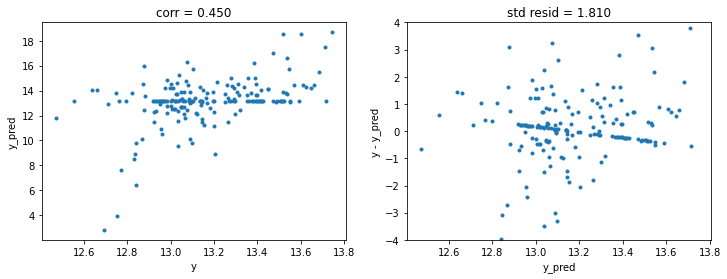

In [42]:
splits = 10
repeats = 10
model=Lasso()
lambda_range = np.arange(0,1,0.001)
param_grid ={
    'alpha': lambda_range
}
best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=scaled_x, y=data_y)




In [36]:
feature_names=list(scaled_x.columns)
feature_coeff = best_model.coef_
df_importance = pd.Series(feature_coeff, index=feature_names)
df_importance

RBM5          0.0
CDC27         0.0
CREBBP        0.0
MED24         0.0
CSDE1         0.0
             ... 
ZNF292_mut    0.0
ZNF638_mut    0.0
ZNF750_mut   -0.0
ZNF814_mut    0.0
ZNRF3_mut     0.0
Length: 912, dtype: float64

In [43]:
df_importance.nlargest(3)

VHL      0.155497
BCOR     0.078955
TCF12    0.042693
dtype: float64

In [46]:
data_x = df_x.loc[:,features]
data_y = df_drug_response['ERLOTINIB']

scaler = StandardScaler()
scaled_val = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_val, columns=data_x.columns)

In [47]:
feature_names=list(scaled_x.columns)
feature_coeff = best_model.coef_
df_importance = pd.Series(feature_coeff, index=feature_names)
df_importance

RBM5          0.0
CDC27         0.0
CREBBP        0.0
MED24         0.0
CSDE1         0.0
             ... 
ZNF292_mut    0.0
ZNF638_mut    0.0
ZNF750_mut   -0.0
ZNF814_mut    0.0
ZNRF3_mut     0.0
Length: 912, dtype: float64

In [49]:
df_importance.nlargest(5)

VHL      0.141548
BCOR     0.071007
TCF12    0.036482
RBM5     0.000000
CDC27    0.000000
dtype: float64